In [1]:
%matplotlib inline

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sb
from matplotlib.pyplot import cm

In [3]:
sb.set_style("darkgrid",{"axes.facecolor":".9"})

In [4]:
features = joblib.load("/mnt/shared_drive/data/brain_therapy/BT_MVP_Content_Pilot/MVP_Focused_Attention/pkls/feature_pkls/new_features.pkl")

In [5]:
features.head()

ecg_heart_rate  ecg_hrv_std  \
Participant Type context Datetime                                               
0001        2D   LL      2019-07-10 15:27:32.344       66.617321    75.818192   
                         2019-07-10 15:27:37.748       68.807339          NaN   
                         2019-07-10 15:27:42.980       61.525841          NaN   
                         2019-07-10 15:27:47.856       65.047702          NaN   
                         2019-07-10 15:27:52.468       61.174551    86.211057   

                                                  skin_temperature  eda_mean  \
Participant Type context Datetime                                              
0001        2D   LL      2019-07-10 15:27:32.344         12.958056   4.31652   
                         2019-07-10 15:27:37.748               NaN       NaN   
                         2019-07-10 15:27:42.980         12.968002       NaN   
                         2019-07-10 15:27:47.856               NaN       NaN   
                         2019-07-10 15:27:52.468         12.967983       NaN   

                                                  eda_no_of_peaks    eda_lf  \
Participant Type context Datetime                                             
0001        2D   LL      2019-07-10 15:27:32.344              4.0  0.003565   
                         2019-07-10 15:27:37.748              NaN       NaN   
                         2019-07-10 15:27:42.980              NaN       NaN   
                         2019-07-10 15:27:47.856              NaN       NaN   
                         2019-07-10 15:27:52.468              NaN       NaN   

                                                    eda_hf  eda_lf_hf_ratio  \
Participant Type context Datetime                                             
0001        2D   LL      2019-07-10 15:27:32.344  0.002215         1.609201   
                         2019-07-10 15:27:37.748       NaN              NaN   
                         2019-07-10 15:27:42.980       NaN              NaN   
                         2019-07-10 15:27:47.856       NaN              NaN   
                         2019-07-10 15:27:52.468       NaN              NaN   

                                                  feature_time  event_order  \
Participant Type context Datetime                                             
0001        2D   LL      2019-07-10 15:27:32.344             0            1   
                         2019-07-10 15:27:37.748             1            1   
                         2019-07-10 15:27:42.980             2            1   
                         2019-07-10 15:27:47.856             3            1   
                         2019-07-10 15:27:52.468             4            1   

                                                  event_session_order  \
Participant Type context Datetime                                       
0001        2D   LL      2019-07-10 15:27:32.344                    1   
                         2019-07-10 15:27:37.748                    1   
                         2019-07-10 15:27:42.980                    1   
                         2019-07-10 15:27:47.856                    1   
                         2019-07-10 15:27:52.468                    1   

                                                  session_order  
Participant Type context Datetime                                
0001        2D   LL      2019-07-10 15:27:32.344              1  
                         2019-07-10 15:27:37.748              1  
                         2019-07-10 15:27:42.980              1  
                         2019-07-10 15:27:47.856              1  
                         2019-07-10 15:27:52.468              1

In [6]:
cols = features.columns[:-4]

In [7]:
feature_dict = {}
for col in cols:
    feature_dict[col] = features[[col]]
    

In [8]:
feature_dict.keys()

dict_keys(['ecg_heart_rate', 'ecg_hrv_std', 'skin_temperature', 'eda_mean', 'eda_no_of_peaks', 'eda_lf', 'eda_hf', 'eda_lf_hf_ratio'])

In [9]:
def compute_slope(participant): 
    slopes_df = pd.DataFrame([])
    flag = True
    for index, data in feature_dict.items():

        two_d = data.loc(axis = 0)[participant,'2D',:,:].dropna()
        events_two = two_d.index.get_level_values("context").unique().values
        two_dxt = two_d.index.get_level_values("Datetime")
        two_dx = np.arange(0,len(two_dxt))
        two_dy = two_d[index].values
        slope_two,intercept_two,_,p_value_two,_ = sc.linregress(two_dx, two_dy)

        df2 = pd.DataFrame([['2D',{"slope":slope_two,"intercept":intercept_two,"p_value":p_value_two}]], 
                           columns = ['type',index ])
        three_d = data.loc(axis = 0)[participant,'3D',:,:].dropna()
        events_three = three_d.index.get_level_values("context").unique().values
        three_dxt = three_d.index.get_level_values("Datetime")
        three_dx = np.arange(0,len(three_dxt))
        three_dy = three_d[index].values
        slope_three,intercept_three,_,p_value_three,_ = sc.linregress(three_dx, three_dy)
        
        df3 = pd.DataFrame([['3D',{"slope":slope_three,"intercept":intercept_three,"p_value":p_value_three}]], 
                           columns = ['type',index ])

        df_complete = pd.concat([df2,df3])
        df_complete.set_index(['type'], inplace = True)
        if flag:
            slopes_df = df_complete
            flag = False
        else:
            slopes_df = slopes_df.merge(df_complete, how = 'left', right_index = True, left_index = True)
        
    return slopes_df

In [10]:
slopes = features.groupby("Participant").apply(lambda x: compute_slope(x.index.get_level_values("Participant").unique().values))

In [11]:
slopes.head()

ecg_heart_rate  \
Participant type                                                      
0001        2D    {'slope': -0.004176884080111639, 'intercept': ...   
            3D    {'slope': 0.011136773373650455, 'intercept': 6...   
0002        2D    {'slope': 0.04576437219942525, 'intercept': 75...   
            3D    {'slope': 0.0470008158863629, 'intercept': 66....   
0003        2D    {'slope': 0.00303020835062283, 'intercept': 53...   

                                                        ecg_hrv_std  \
Participant type                                                      
0001        2D    {'slope': -0.8866135555649748, 'intercept': 91...   
            3D    {'slope': 0.846668721256036, 'intercept': 59.2...   
0002        2D    {'slope': 0.048234721267762036, 'intercept': 5...   
            3D    {'slope': -2.0274474607363215, 'intercept': 84...   
0003        2D    {'slope': -1.027900939523154, 'intercept': 90....   

                                                   skin_temperature  \
Participant type                                                      
0001        2D    {'slope': -3.0909616627582604e-05, 'intercept'...   
            3D    {'slope': 0.0002480494892763653, 'intercept': ...   
0002        2D    {'slope': -0.0030462814257143046, 'intercept':...   
            3D    {'slope': 0.005387199306314003, 'intercept': 3...   
0003        2D    {'slope': -0.004046638318012675, 'intercept': ...   

                                                           eda_mean  \
Participant type                                                      
0001        2D    {'slope': -0.04763341480554465, 'intercept': 3...   
            3D    {'slope': 0.030294955048272013, 'intercept': 6...   
0002        2D    {'slope': -0.16326060913624443, 'intercept': 1...   
            3D    {'slope': -0.2762695676418678, 'intercept': 15...   
0003        2D    {'slope': 0.014284297897431865, 'intercept': 4...   

                                                    eda_no_of_peaks  \
Participant type                                                      
0001        2D    {'slope': -0.03823529411764706, 'intercept': 6...   
            3D    {'slope': 0.11470588235294117, 'intercept': 4....   
0002        2D    {'slope': 0.08529411764705883, 'intercept': 10...   
            3D    {'slope': 0.27205882352941174, 'intercept': 5....   
0003        2D    {'slope': 0.5970588235294118, 'intercept': 4.6...   

                                                             eda_lf  \
Participant type                                                      
0001        2D    {'slope': -6.162117966863682e-05, 'intercept':...   
            3D    {'slope': -0.00014046562727691391, 'intercept'...   
0002        2D    {'slope': -7.455132773204692e-05, 'intercept':...   
            3D    {'slope': -0.00014768469471536196, 'intercept'...   
0003        2D    {'slope': -5.932007783459933e-06, 'intercept':...   

                                                             eda_hf  \
Participant type                                                      
0001        2D    {'slope': -2.9704165859708528e-05, 'intercept'...   
            3D    {'slope': -0.00011684412644958586, 'intercept'...   
0002        2D    {'slope': -5.544344279911331e-05, 'intercept':...   
            3D    {'slope': -6.940342826441102e-05, 'intercept':...   
0003        2D    {'slope': -1.157886591738913e-05, 'intercept':...   

                                                    eda_lf_hf_ratio  
Participant type                                                     
0001        2D    {'slope': 0.01906770217146901, 'intercept': 2....  
            3D    {'slope': 0.020617699573935118, 'intercept': 2...  
0002        2D    {'slope': 0.016361134135547965, 'intercept': 1...  
            3D    {'slope': 0.0296581429209018, 'intercept': 1.8...  
0003        2D    {'slope': -0.10500304968727546, 'intercept': 2...

In [12]:
slopes.head()

ecg_heart_rate  \
Participant type                                                      
0001        2D    {'slope': -0.004176884080111639, 'intercept': ...   
            3D    {'slope': 0.011136773373650455, 'intercept': 6...   
0002        2D    {'slope': 0.04576437219942525, 'intercept': 75...   
            3D    {'slope': 0.0470008158863629, 'intercept': 66....   
0003        2D    {'slope': 0.00303020835062283, 'intercept': 53...   

                                                        ecg_hrv_std  \
Participant type                                                      
0001        2D    {'slope': -0.8866135555649748, 'intercept': 91...   
            3D    {'slope': 0.846668721256036, 'intercept': 59.2...   
0002        2D    {'slope': 0.048234721267762036, 'intercept': 5...   
            3D    {'slope': -2.0274474607363215, 'intercept': 84...   
0003        2D    {'slope': -1.027900939523154, 'intercept': 90....   

                                                   skin_temperature  \
Participant type                                                      
0001        2D    {'slope': -3.0909616627582604e-05, 'intercept'...   
            3D    {'slope': 0.0002480494892763653, 'intercept': ...   
0002        2D    {'slope': -0.0030462814257143046, 'intercept':...   
            3D    {'slope': 0.005387199306314003, 'intercept': 3...   
0003        2D    {'slope': -0.004046638318012675, 'intercept': ...   

                                                           eda_mean  \
Participant type                                                      
0001        2D    {'slope': -0.04763341480554465, 'intercept': 3...   
            3D    {'slope': 0.030294955048272013, 'intercept': 6...   
0002        2D    {'slope': -0.16326060913624443, 'intercept': 1...   
            3D    {'slope': -0.2762695676418678, 'intercept': 15...   
0003        2D    {'slope': 0.014284297897431865, 'intercept': 4...   

                                                    eda_no_of_peaks  \
Participant type                                                      
0001        2D    {'slope': -0.03823529411764706, 'intercept': 6...   
            3D    {'slope': 0.11470588235294117, 'intercept': 4....   
0002        2D    {'slope': 0.08529411764705883, 'intercept': 10...   
            3D    {'slope': 0.27205882352941174, 'intercept': 5....   
0003        2D    {'slope': 0.5970588235294118, 'intercept': 4.6...   

                                                             eda_lf  \
Participant type                                                      
0001        2D    {'slope': -6.162117966863682e-05, 'intercept':...   
            3D    {'slope': -0.00014046562727691391, 'intercept'...   
0002        2D    {'slope': -7.455132773204692e-05, 'intercept':...   
            3D    {'slope': -0.00014768469471536196, 'intercept'...   
0003        2D    {'slope': -5.932007783459933e-06, 'intercept':...   

                                                             eda_hf  \
Participant type                                                      
0001        2D    {'slope': -2.9704165859708528e-05, 'intercept'...   
            3D    {'slope': -0.00011684412644958586, 'intercept'...   
0002        2D    {'slope': -5.544344279911331e-05, 'intercept':...   
            3D    {'slope': -6.940342826441102e-05, 'intercept':...   
0003        2D    {'slope': -1.157886591738913e-05, 'intercept':...   

                                                    eda_lf_hf_ratio  
Participant type                                                     
0001        2D    {'slope': 0.01906770217146901, 'intercept': 2....  
            3D    {'slope': 0.020617699573935118, 'intercept': 2...  
0002        2D    {'slope': 0.016361134135547965, 'intercept': 1...  
            3D    {'slope': 0.0296581429209018, 'intercept': 1.8...  
0003        2D    {'slope': -0.10500304968727546, 'intercept': 2...

In [13]:
def plot_data(participant, data, slopes):
    types = data.index.get_level_values("Type").unique().values
    feature_names = feature_dict.keys()
    fig, axes = plt.subplots(8,2, figsize = (10,25), dpi = 250)
    ax = axes.flatten()
    for i, type_ in enumerate(types):
        d = data.loc(axis = 0)[participant, type_, :,:]
        events = d.index.get_level_values("context").unique()
        count = 0
        for index in feature_names: 
            index_data = d[[index]].dropna()
            dxt = index_data.index.get_level_values("Datetime")
            dx = np.arange(0,len(dxt))
            dy = index_data[index].values

            slope, intercept, p_value = slopes.loc(axis = 0)[participant,type_][index].values[0].values()
            ax[i+count].plot(dx, dy, 'o')
            ax[i+count].plot(dx, intercept + slope*dx,  color = 'red')
            llim, ulim = ax[i+count].get_ylim()

            colors = {'HH':'#ffb8a7',"HL":'#beedcd','LH':'#e0eb1c','LL':'#59b6eb'}
            for event in events:
                event_data = index_data.loc(axis = 0)[:,:,event,:]
                times = event_data.index.get_level_values("Datetime")
                d_first = list(dxt).index(times[0])
                d_last = list(dxt).index(times[len(times)-1])
                ax[i+count].axvspan(d_first,d_last+1, color = colors[event], alpha=0.2, zorder=2)

                ax[i+count].annotate('{}'.format(event), (d_first,ulim), rotation=90)

            ax[i+count].set_title("Participant-{} \n {}:{} \n  Slope : {} | P_value : {} ".format(participant[0],index.upper(),
                                                                          type_,np.round(slope,3),
                                                                          np.round(p_value,3)))
            ax[i+count].set_ylim([llim,llim+(np.abs(ulim-llim)*2)])

        
            count+=2
        
        plt.suptitle("Participant {}".format(participant[0]), y = 1.03, size = 15)
        plt.tight_layout()
    plt.tight_layout()

In [14]:
some_parts = features.loc(axis = 0)[['0002','0003','0004','0005']]

Empty DataFrame
Columns: []
Index: []

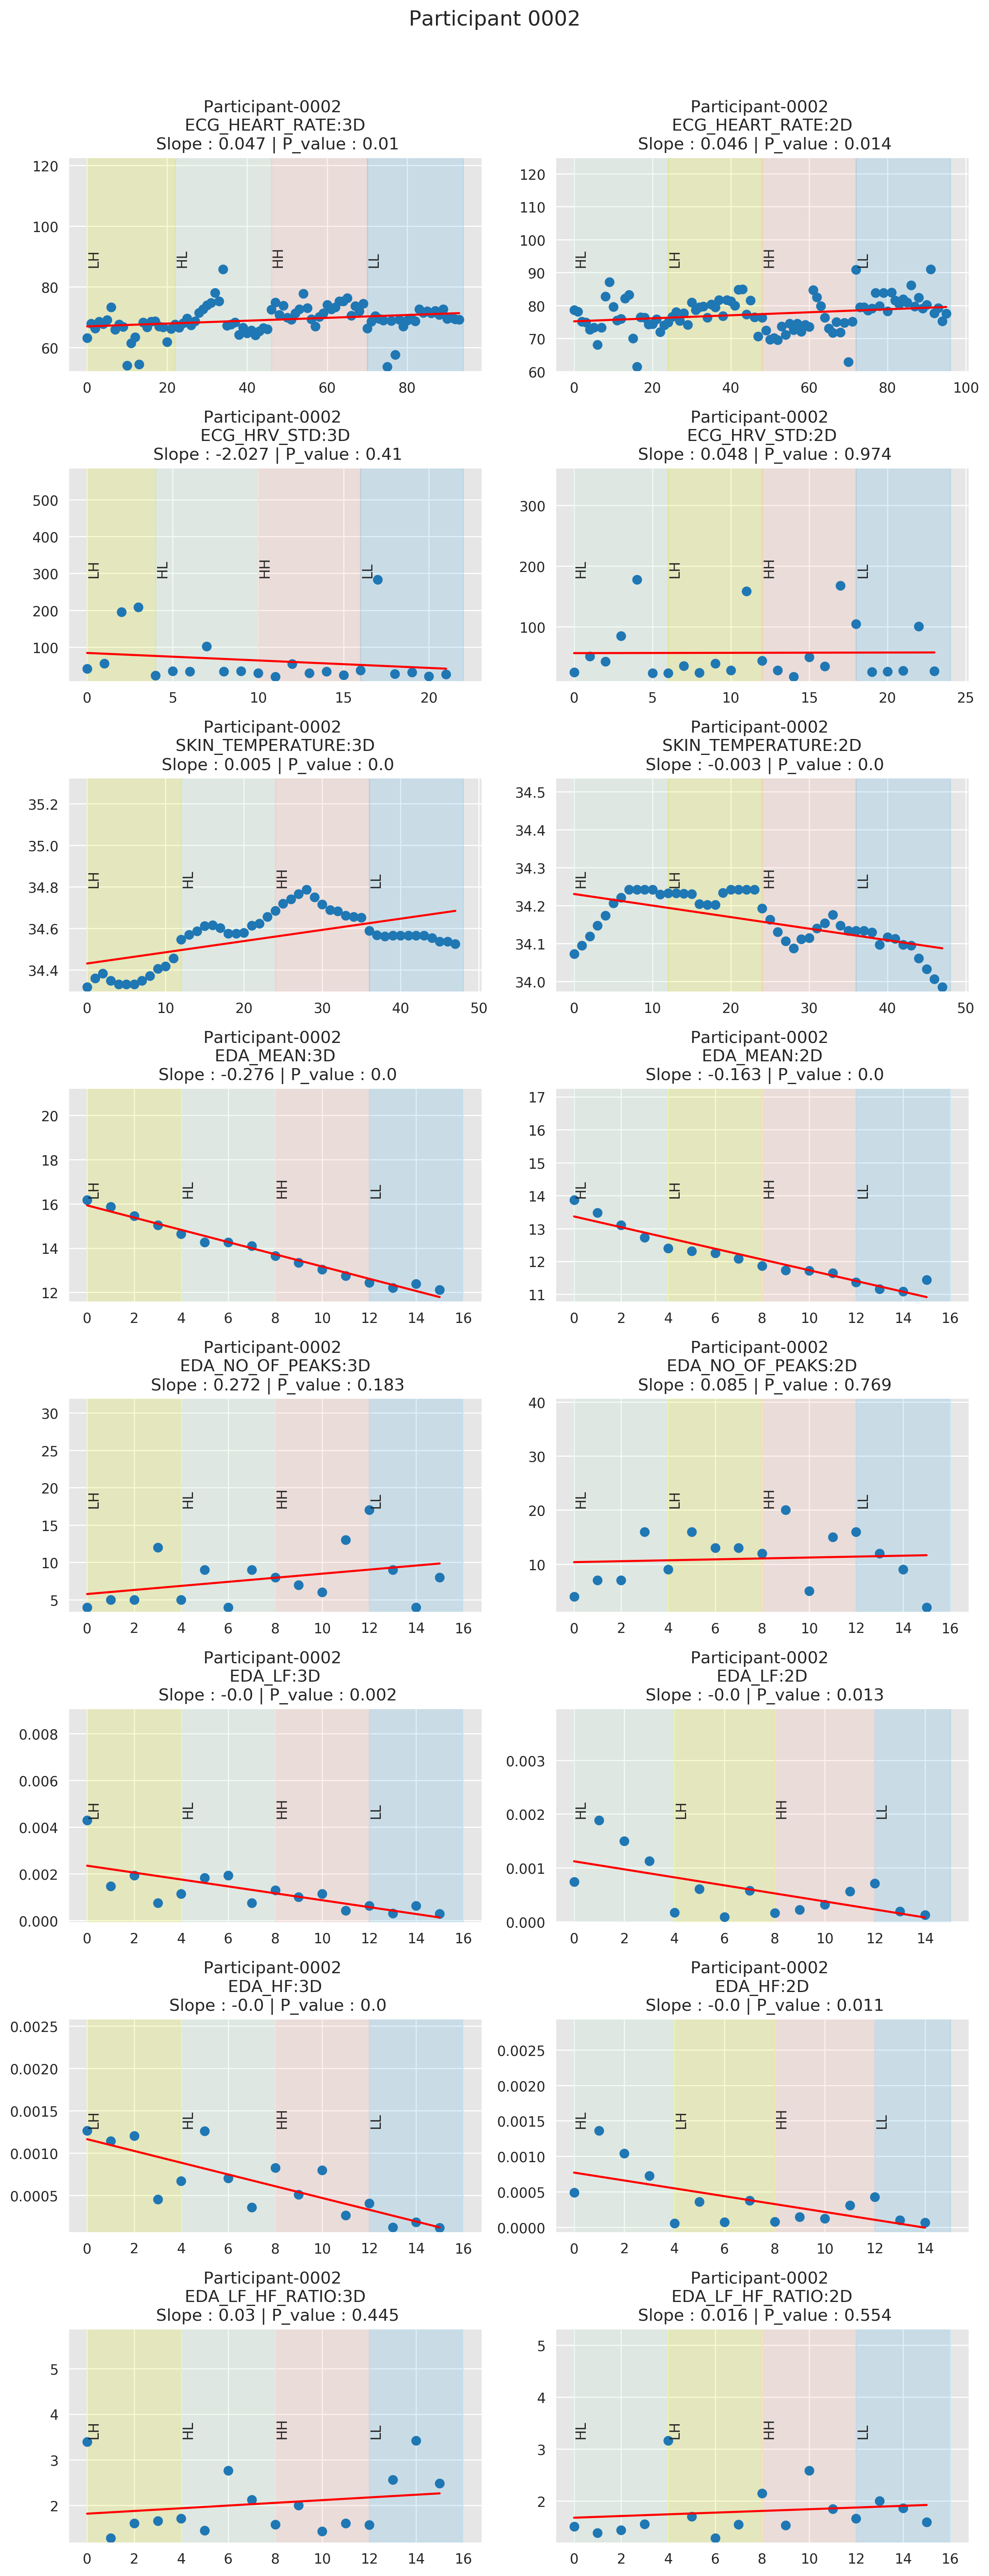

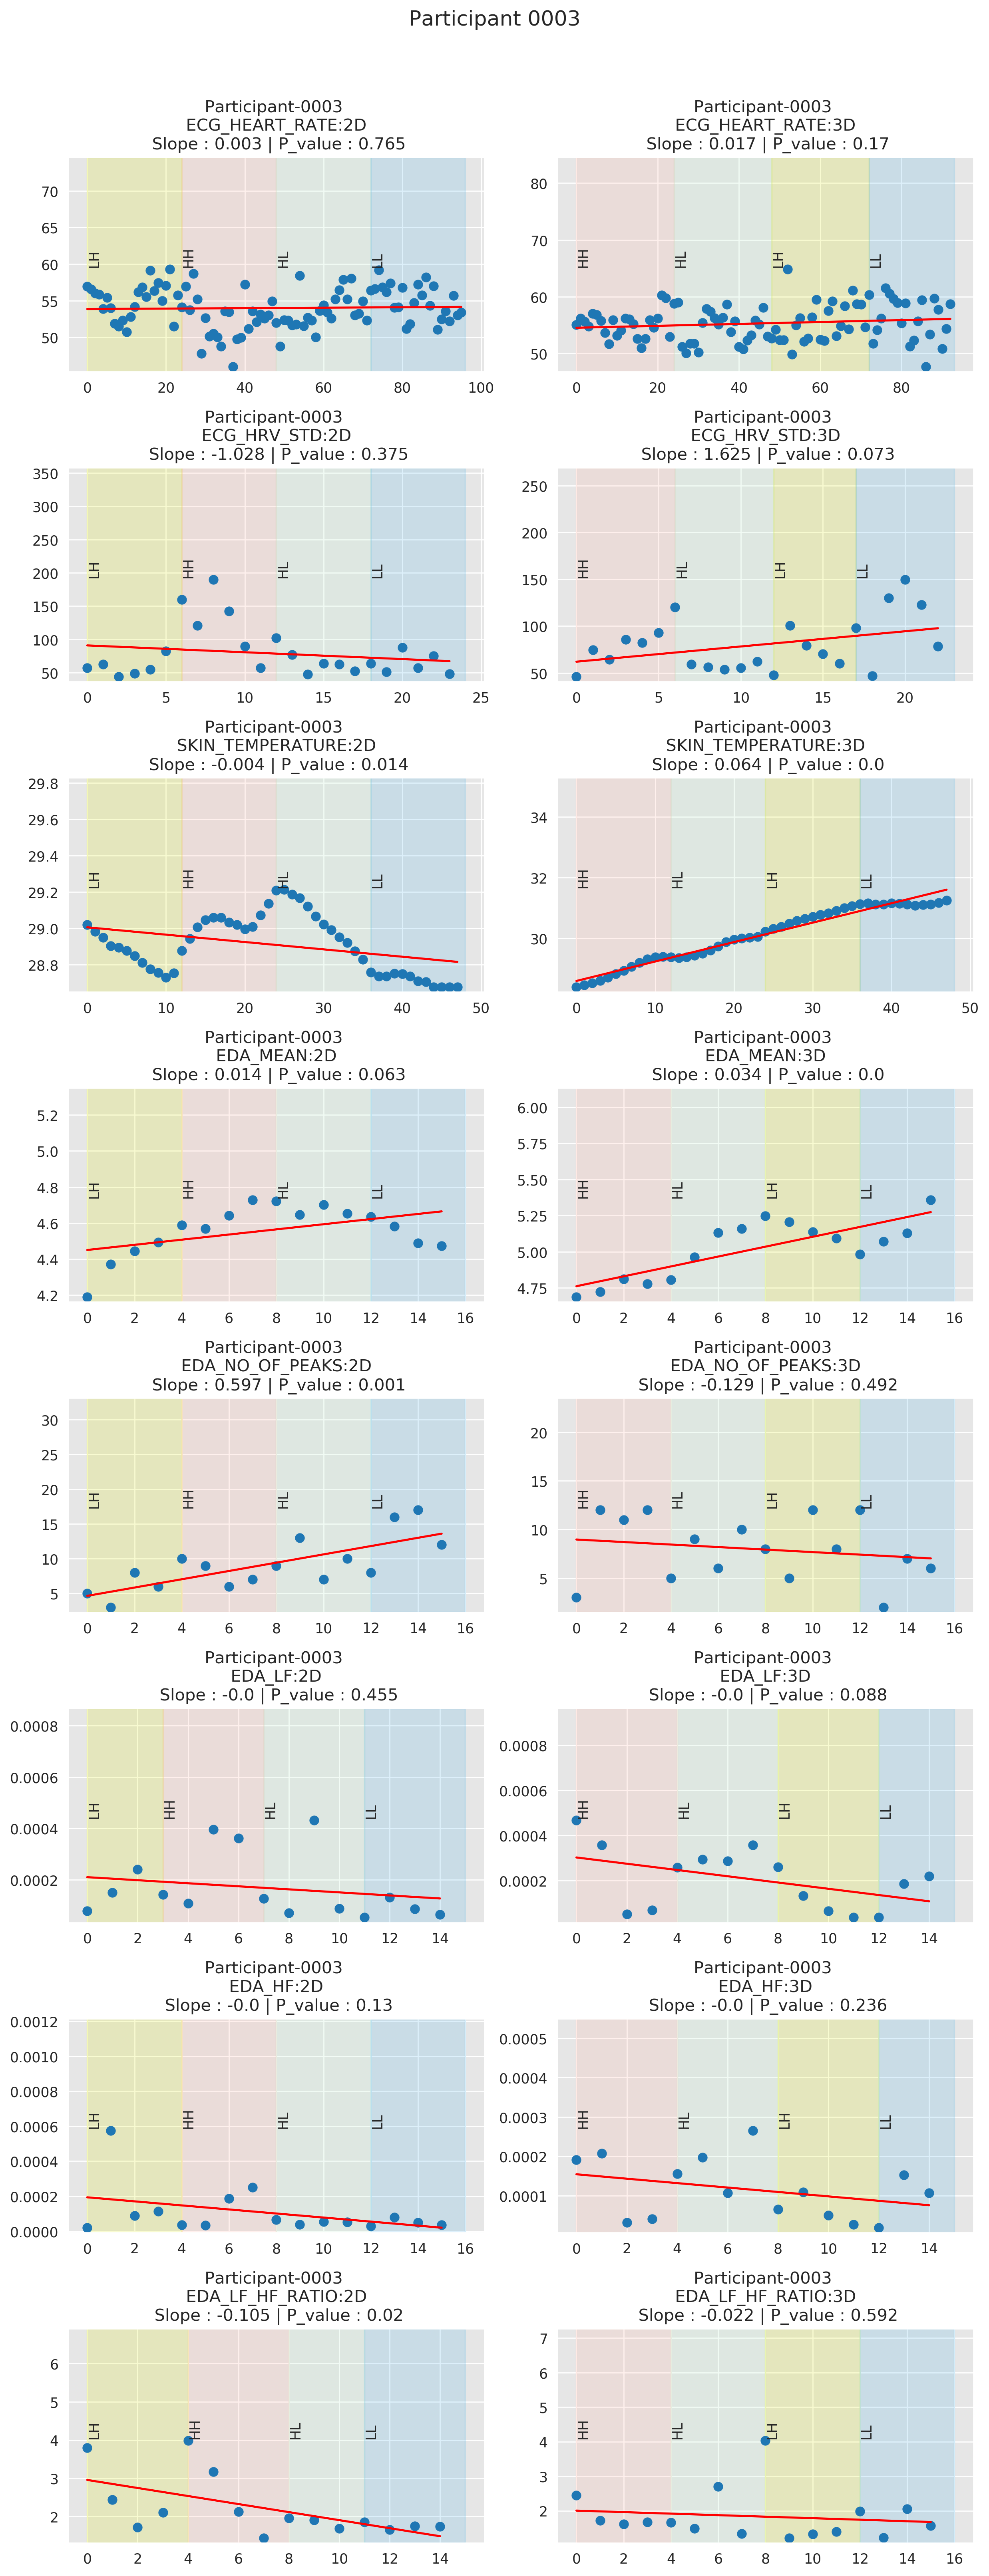

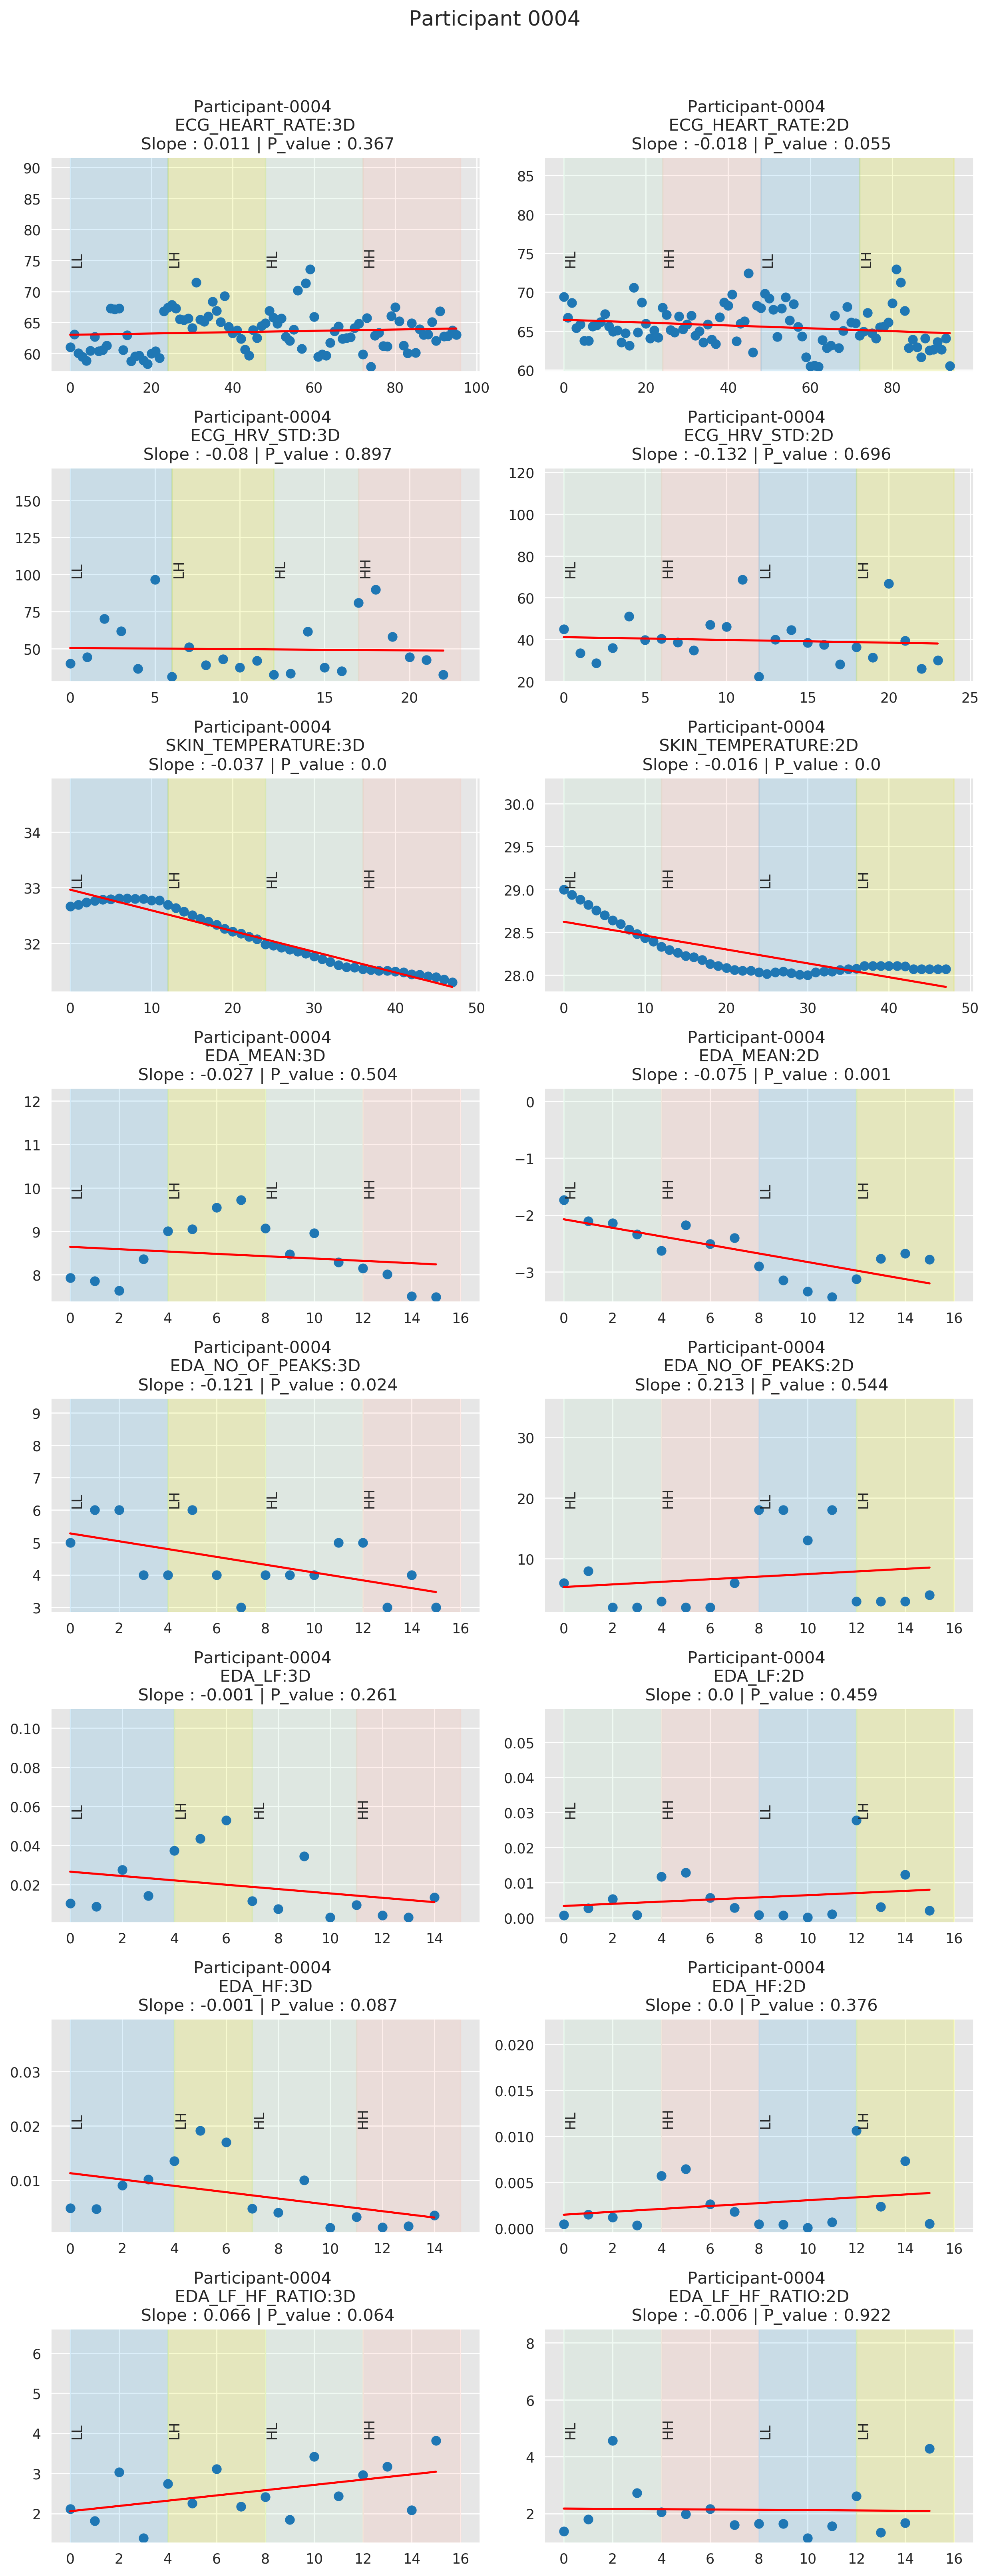

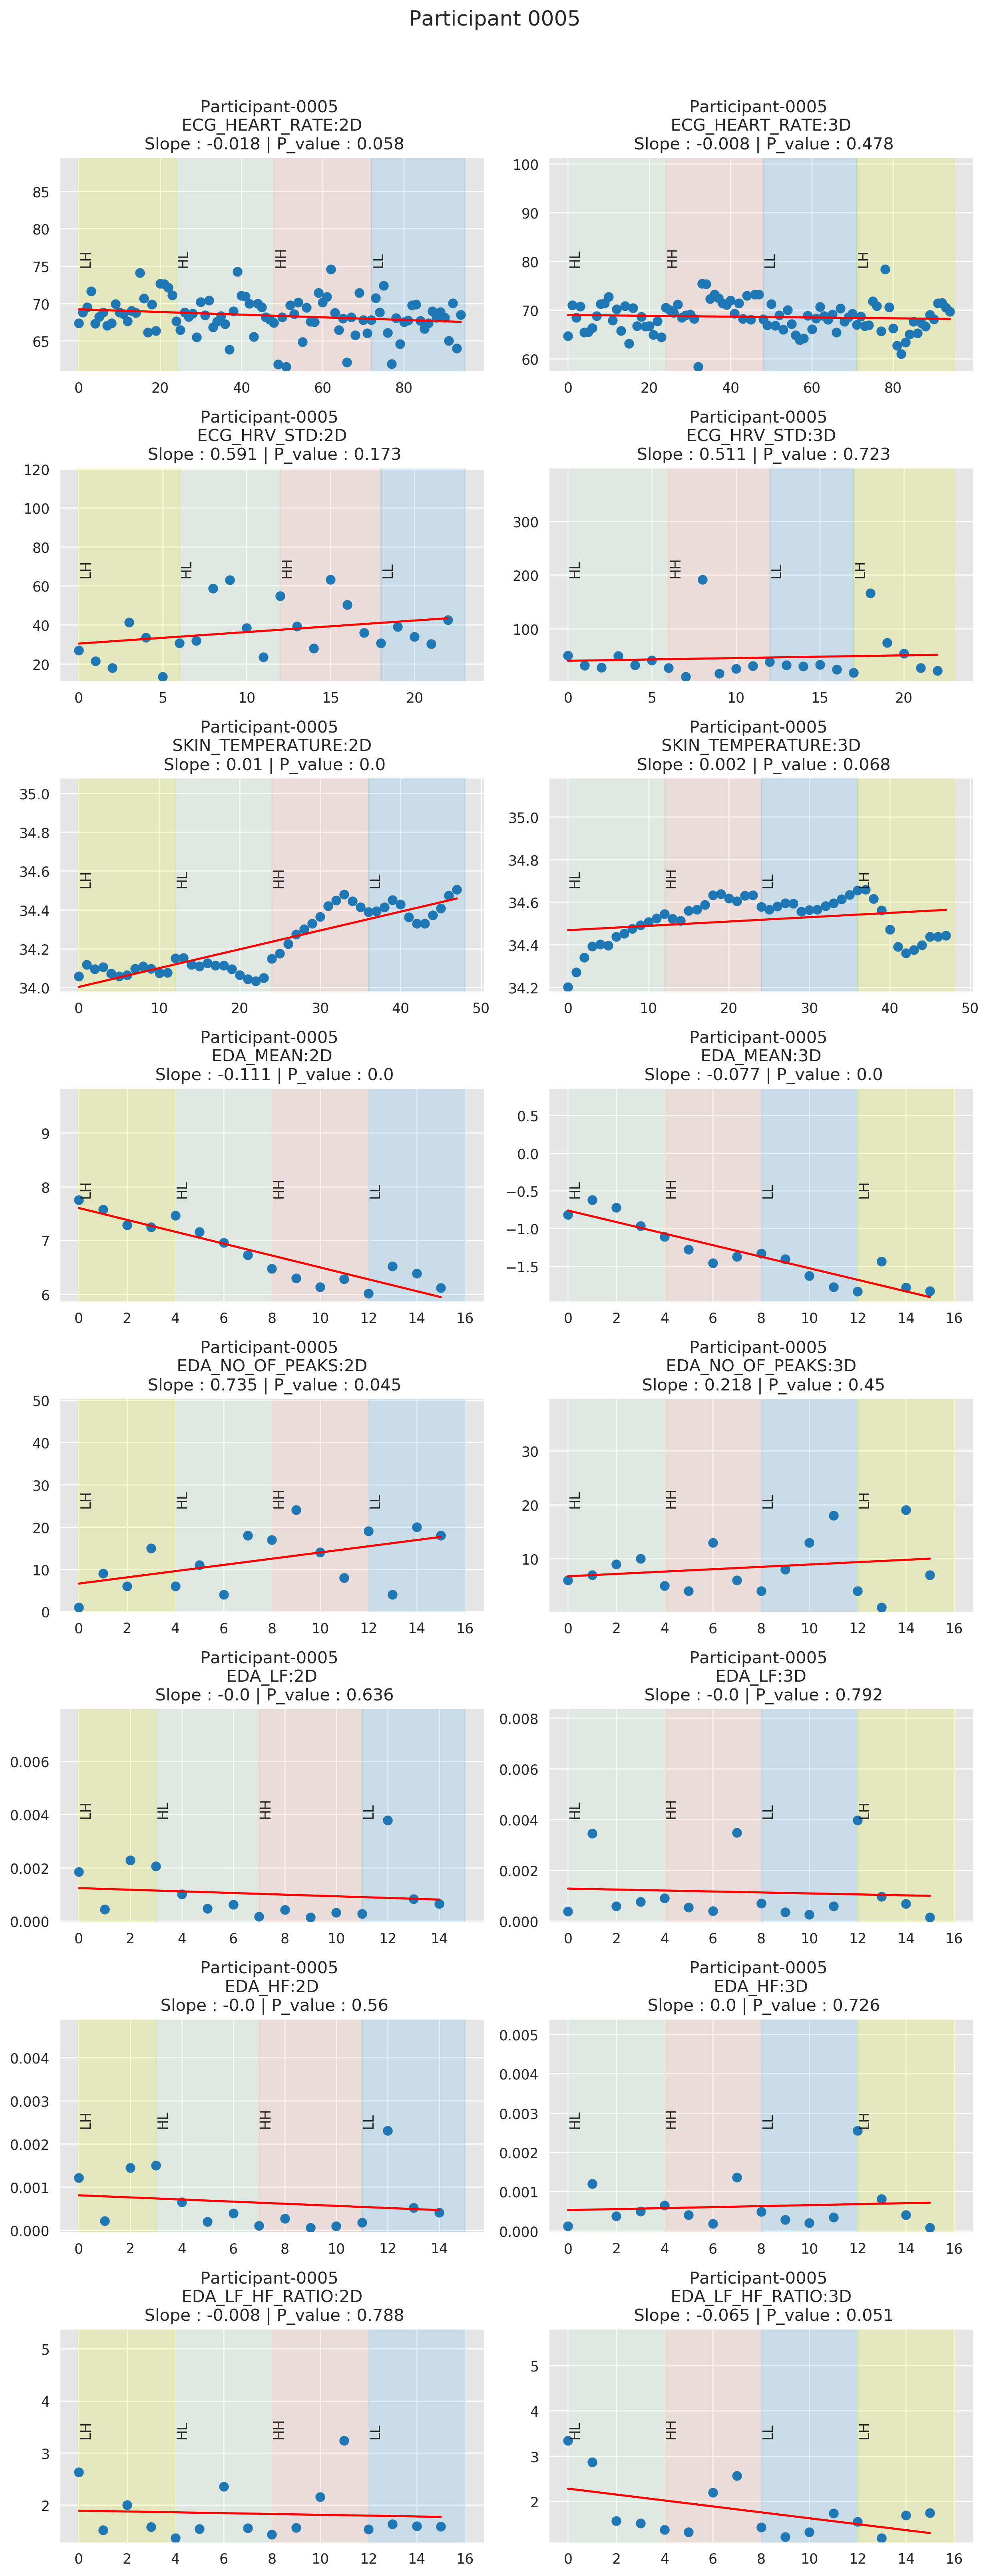

In [15]:
some_parts.groupby(["Participant"]).apply(lambda x: plot_data(x.index.get_level_values("Participant").unique().values,x, slopes))

#### Trend Analysis Both 2D and 3D

In [16]:
def compute_slope_all(participant,data): 
    slopes_df = pd.DataFrame([])
    features = feature_dict.keys()
    flag = True
    for feature in features:
        feature_data = data[[feature]].dropna()
        dxt = feature_data.index.get_level_values("Datetime")
        dx = np.arange(0,len(dxt))
        dy = feature_data[feature].values
        slope_three,intercept_three,_,p_value_three,_ = sc.linregress(dx, dy)
        
        df = pd.DataFrame([[{"slope":slope_three,"intercept":intercept_three,"p_value":p_value_three}]], 
                           columns = [feature])
        if flag:
            slopes_df = df
            flag = False
        else:
            slopes_df = slopes_df.merge(df, how = 'left', right_index = True, left_index = True)
        
    return slopes_df

In [17]:
slopes_all = features.groupby("Participant").apply(lambda x: compute_slope_all(x.index.get_level_values("Participant").unique().values[0],x))

In [18]:
slopes_all.head()

ecg_heart_rate  \
Participant                                                        
0001        0  {'slope': 0.015449192634087158, 'intercept': 6...   
0002        0  {'slope': 0.0765564832828322, 'intercept': 66....   
0003        0  {'slope': 0.012930513597724213, 'intercept': 5...   
0004        0  {'slope': 0.015225905015522097, 'intercept': 6...   
0005        0  {'slope': -0.0016929057084098548, 'intercept':...   

                                                     ecg_hrv_std  \
Participant                                                        
0001        0  {'slope': -0.4140368315452187, 'intercept': 84...   
0002        0  {'slope': -0.4216135163709043, 'intercept': 69...   
0003        0  {'slope': 0.07715454854605071, 'intercept': 77...   
0004        0  {'slope': -0.341308723131817, 'intercept': 52....   
0005        0  {'slope': 0.4273762034009917, 'intercept': 31....   

                                                skin_temperature  \
Participant                                                        
0001        0  {'slope': -3.059896547575981e-05, 'intercept':...   
0002        0  {'slope': -0.0059347815575986045, 'intercept':...   
0003        0  {'slope': 0.026040307976379868, 'intercept': 2...   
0004        0  {'slope': -0.06680006600467454, 'intercept': 3...   
0005        0  {'slope': 0.005919631687909698, 'intercept': 3...   

                                                        eda_mean  \
Participant                                                        
0001        0  {'slope': 0.1532334773745383, 'intercept': 2.6...   
0002        0  {'slope': -0.1352727554586164, 'intercept': 15...   
0003        0  {'slope': 0.02763568543156706, 'intercept': 4....   
0004        0  {'slope': -0.5326012570708629, 'intercept': 11...   
0005        0  {'slope': -0.40378124960357953, 'intercept': 8...   

                                                 eda_no_of_peaks  \
Participant                                                        
0001        0  {'slope': -0.025659824046920823, 'intercept': ...   
0002        0  {'slope': 0.1940982404692082, 'intercept': 6.3...   
0003        0  {'slope': 0.005498533724340176, 'intercept': 8...   
0004        0  {'slope': 0.1317815249266862, 'intercept': 3.6...   
0005        0  {'slope': -0.05718475073313783, 'intercept': 1...   

                                                          eda_lf  \
Participant                                                        
0001        0  {'slope': 3.114064806665798e-05, 'intercept': ...   
0002        0  {'slope': -5.977980053414769e-05, 'intercept':...   
0003        0  {'slope': -6.03168146223815e-07, 'intercept': ...   
0004        0  {'slope': -0.0007163408490022723, 'intercept':...   
0005        0  {'slope': -4.759552990675155e-07, 'intercept':...   

                                                          eda_hf  \
Participant                                                        
0001        0  {'slope': 1.0087185355345044e-05, 'intercept':...   
0002        0  {'slope': -2.836028978275162e-05, 'intercept':...   
0003        0  {'slope': -1.8193858936837814e-06, 'intercept'...   
0004        0  {'slope': -0.0002652109157480964, 'intercept':...   
0005        0  {'slope': -1.8915509337651196e-06, 'intercept'...   

                                                 eda_lf_hf_ratio  
Participant                                                       
0001        0  {'slope': -0.0020819704916846342, 'intercept':...  
0002        0  {'slope': -0.0056579330725500315, 'intercept':...  
0003        0  {'slope': -0.03319349617515179, 'intercept': 2...  
0004        0  {'slope': -0.012085670012592042, 'intercept': ...  
0005        0  {'slope': -0.011110283134400932, 'intercept': ...

In [19]:
def plot_context(event_data, event, dxt, ax, colors, ulim):
#     display(event_data)
    times = event_data.index.get_level_values("Datetime")
    d_first = list(dxt).index(times[0])
    d_last = list(dxt).index(times[len(times)-1])
    ax.axvspan(d_first,d_last+1, color = colors[event], alpha=0.2, zorder=2)
    ax.annotate('{}'.format(event), (d_first,ulim), rotation=90)

In [20]:
def plot_all_data(participant, data, slopes):
    feature_names = feature_dict.keys()
    fig, axes = plt.subplots(8,1, figsize = (10,25), dpi = 250)
    ax = axes.flatten()
    events = data.index.get_level_values("context").unique()
  

    for i, feature in enumerate(feature_names): 
        feature_data = data[[feature]].dropna()
        dxt = feature_data.index.get_level_values("Datetime")
        dx = np.arange(0,len(dxt))
        dy = feature_data[feature].values

        slope, intercept, p_value = slopes.loc(axis = 0)[participant][feature].values[0].values()
        ax[i].plot(dx, dy, 'o')
        ax[i].plot(dx, intercept + slope*dx,  color = 'red')
        llim, ulim = ax[i].get_ylim()
        
        
        time_3d = feature_data.loc(axis = 0)[:,'3D',:,:].index.get_level_values("Datetime")[0]
        time_2d = feature_data.loc(axis = 0)[:,'2D',:,:].index.get_level_values("Datetime")[0]
        index_3d = list(dxt).index(time_3d)
        index_2d = list(dxt).index(time_2d)
        
        ax[i].axvline(index_3d, color='darkorange', label='3D Start')
        ax[i].axvline(index_2d, color='darkblue', label='2D Start')

        colors = {'HH':'#ffb8a7',"HL":'#beedcd','LH':'#e0eb1c','LL':'#59b6eb'}
        for event in events:
            event_data = feature_data.loc(axis = 0)[:,:,event,:]
            event_data.groupby(["Participant","Type"]).apply(lambda x: plot_context(x,event, dxt,ax[i],
                                                                                              colors, ulim))
            

        ax[i].set_title("Participant-{} : {} \n  Slope : {} | P_value : {} ".format(participant,feature.upper(),
                                                                      np.round(slope,3),
                                                                      np.round(p_value,3)))
        ax[i].set_ylim([llim,llim+(np.abs(ulim-llim)*2)])
        ax[i].legend()

    plt.suptitle("Participant {}".format(participant), y = 1.03, size = 15)
    plt.tight_layout()


In [21]:
some_participants = features.loc(axis = 0)[['0010','0011','0012','0013'],:,:,:]

Empty DataFrame
Columns: []
Index: []

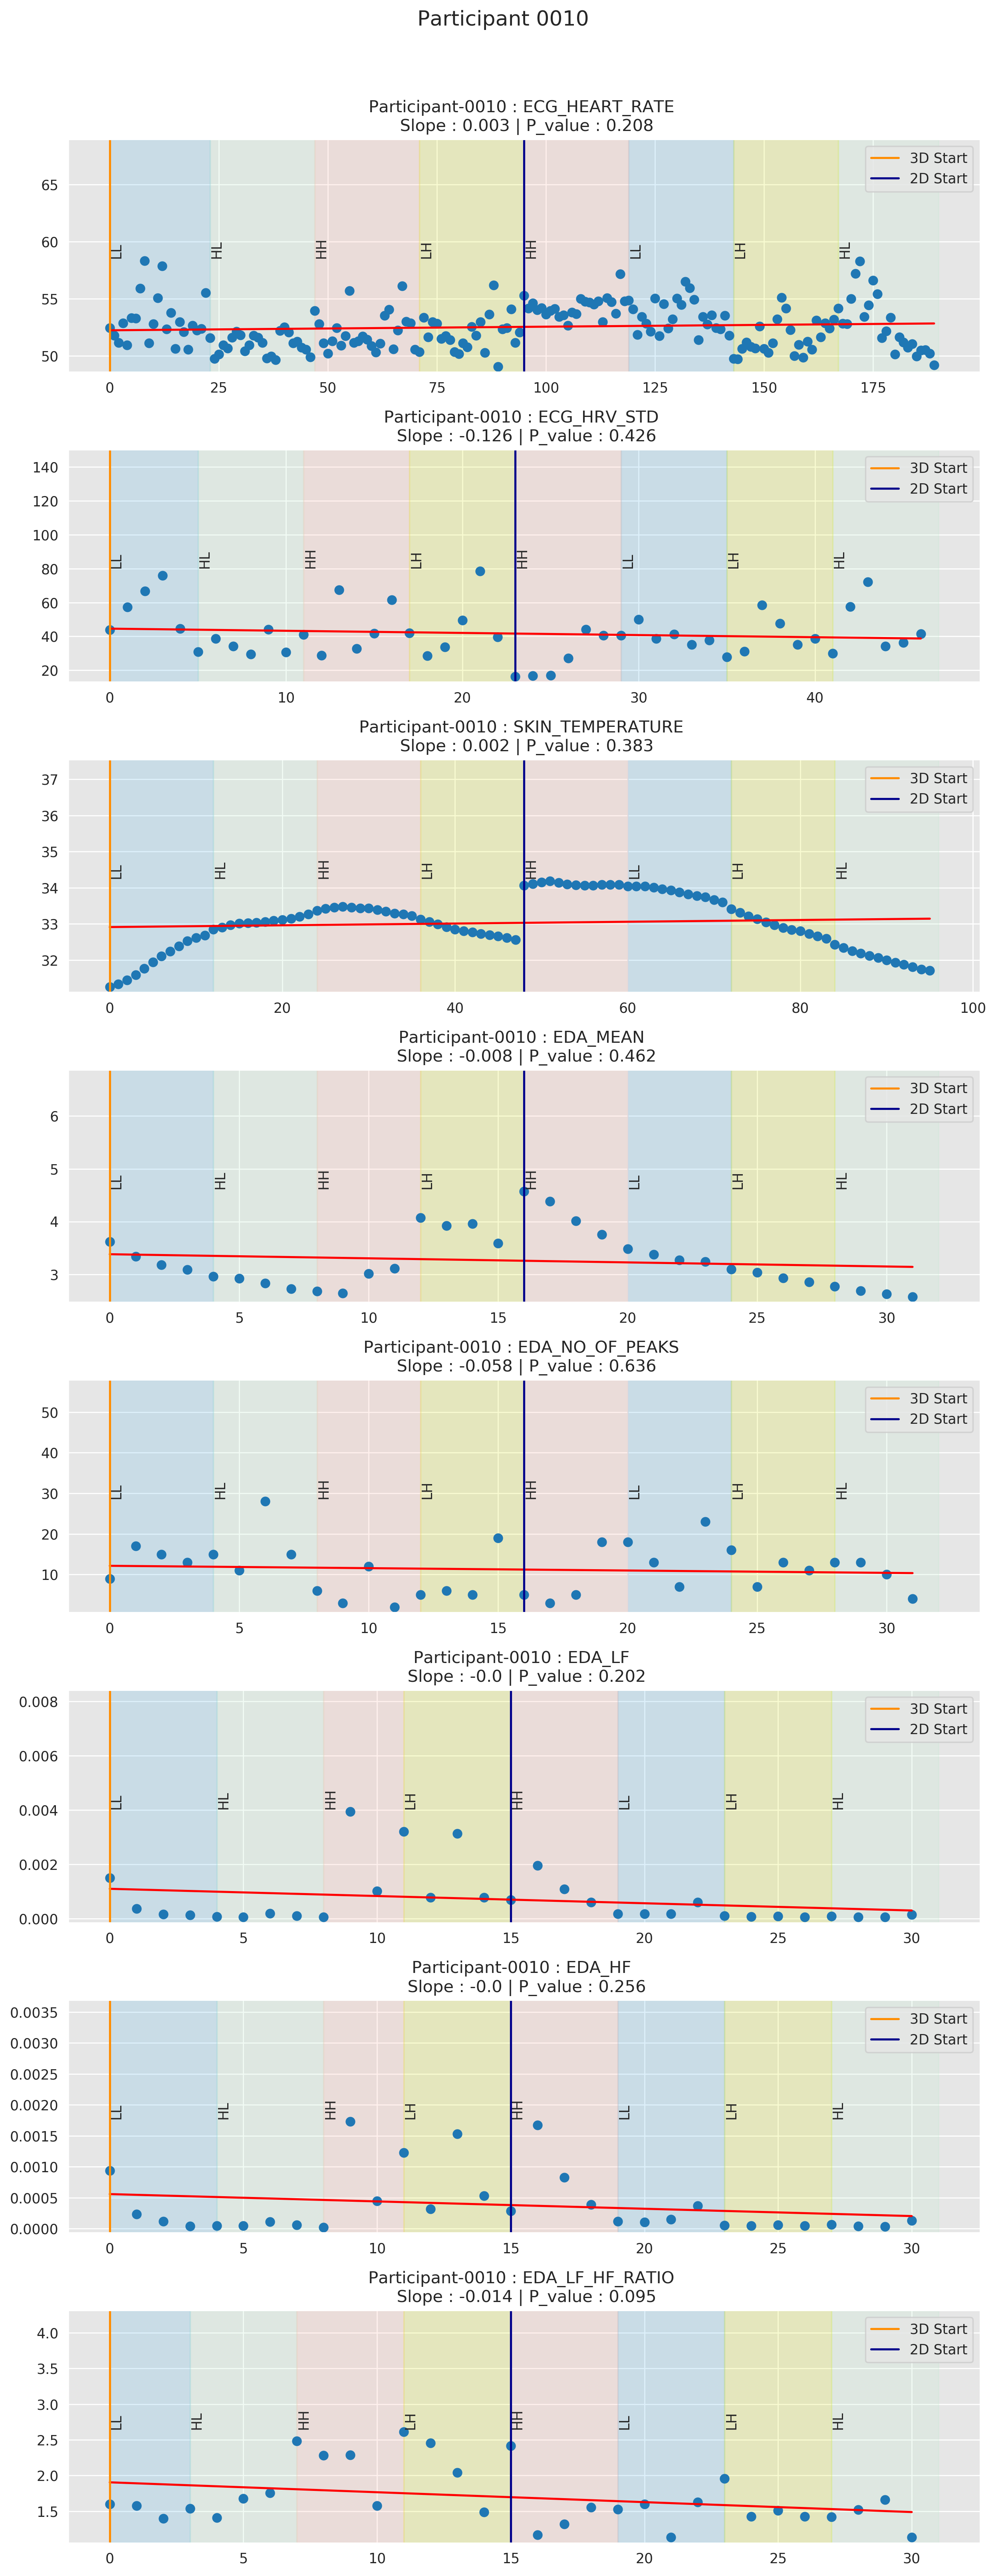

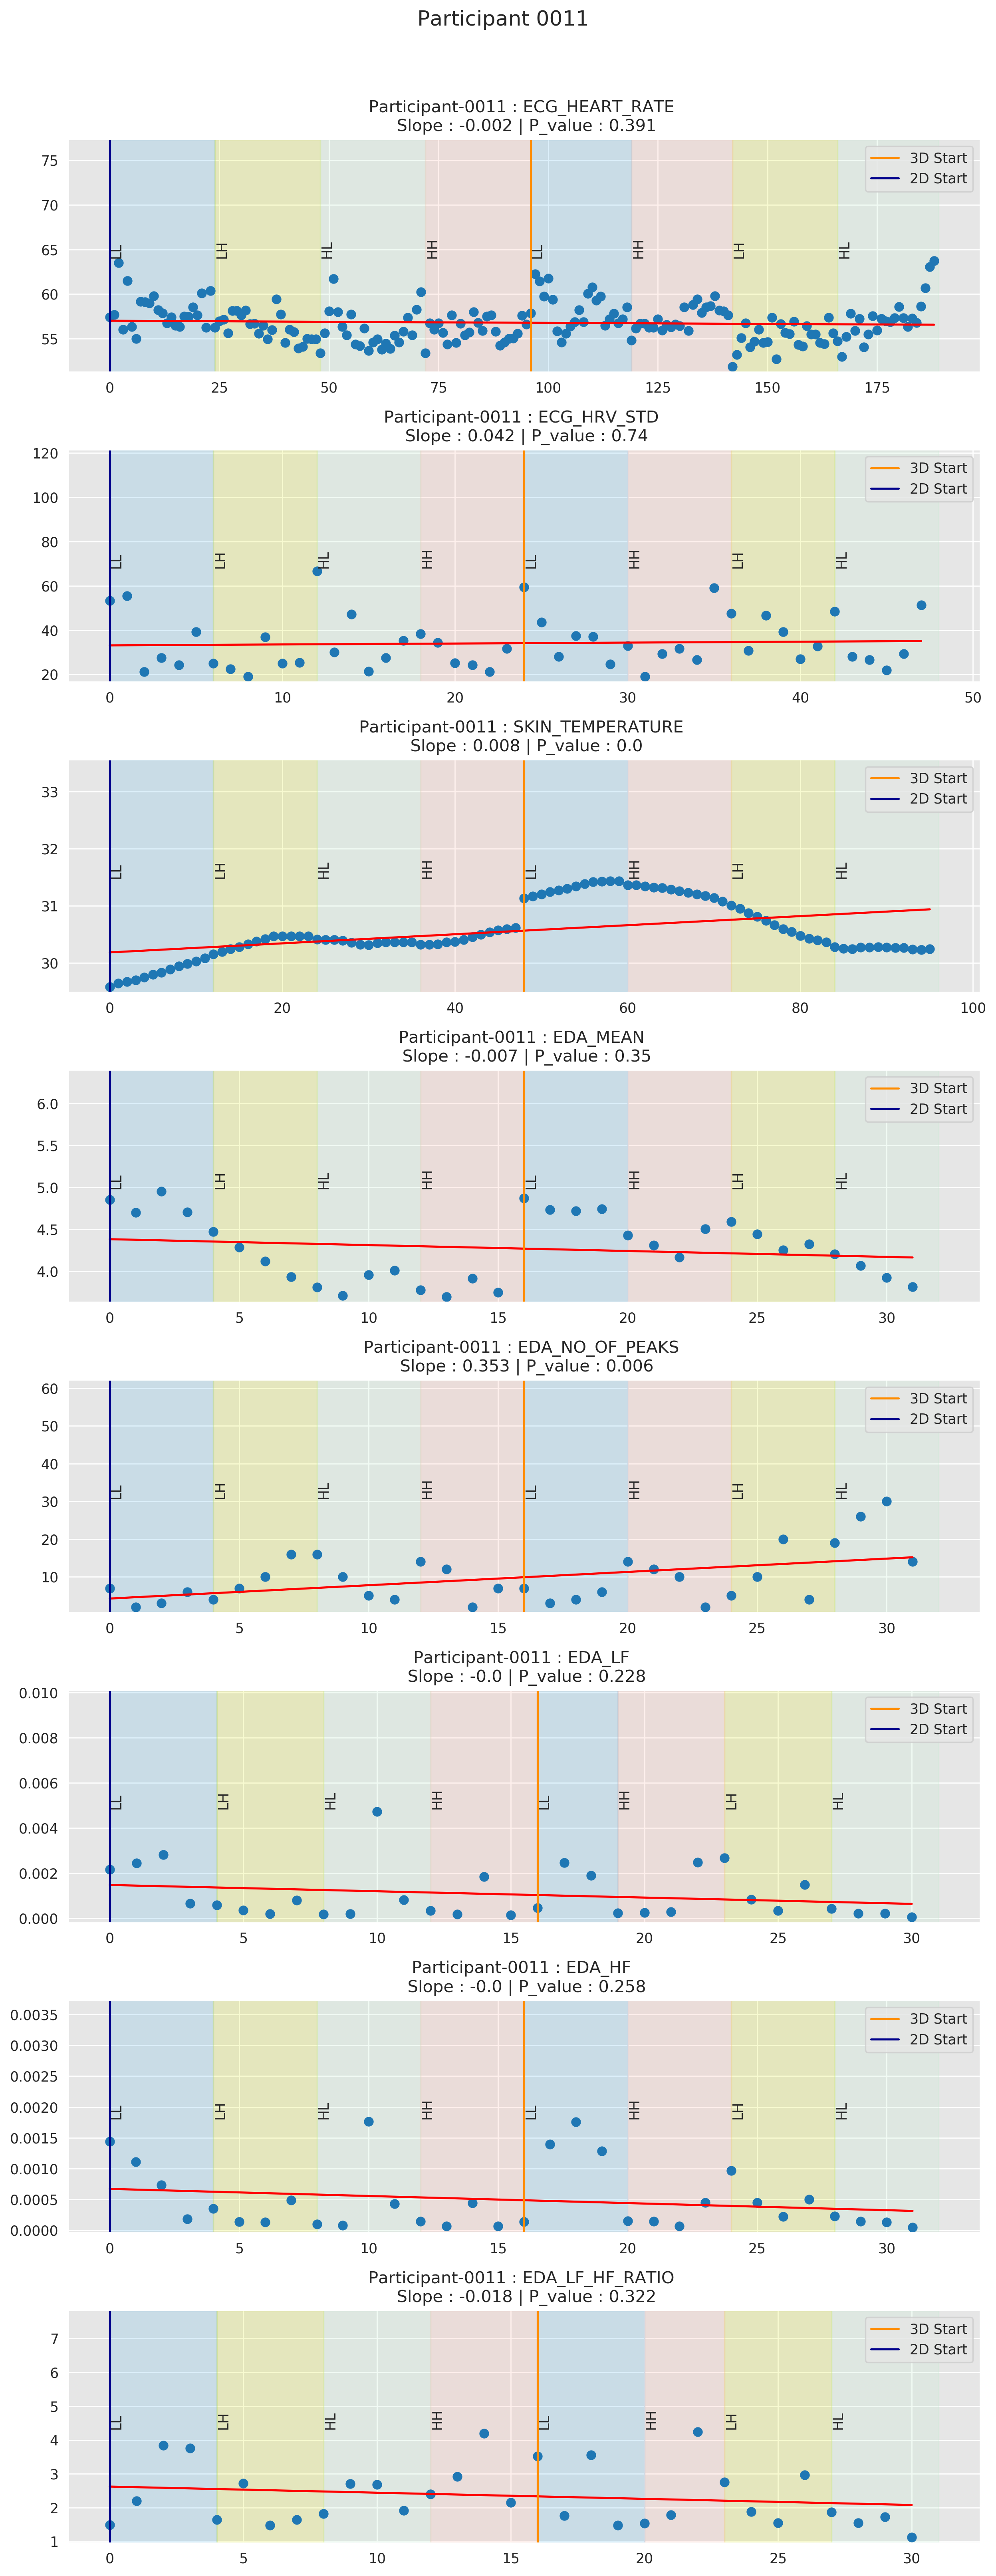

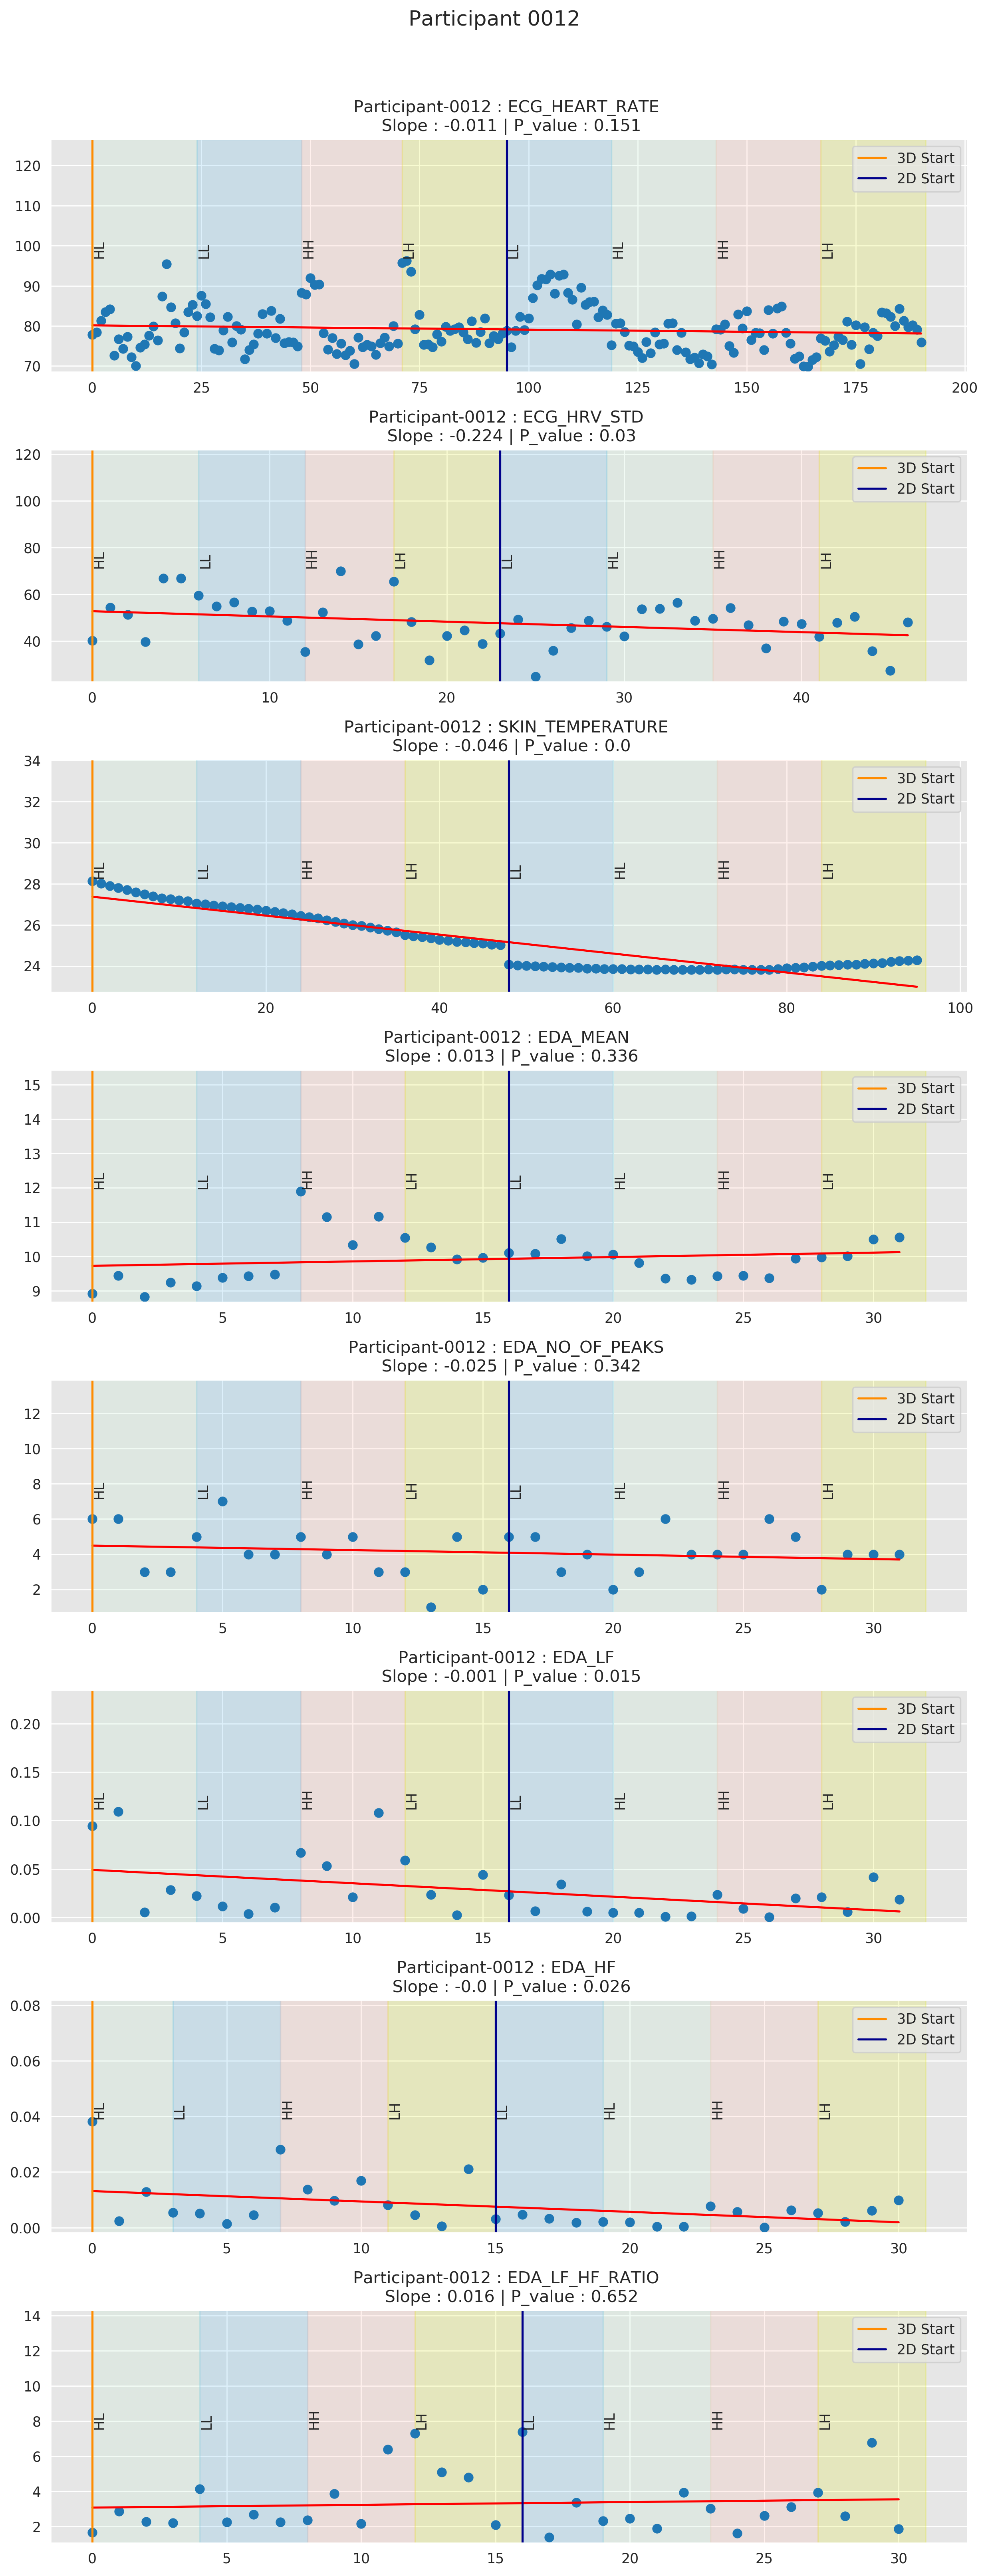

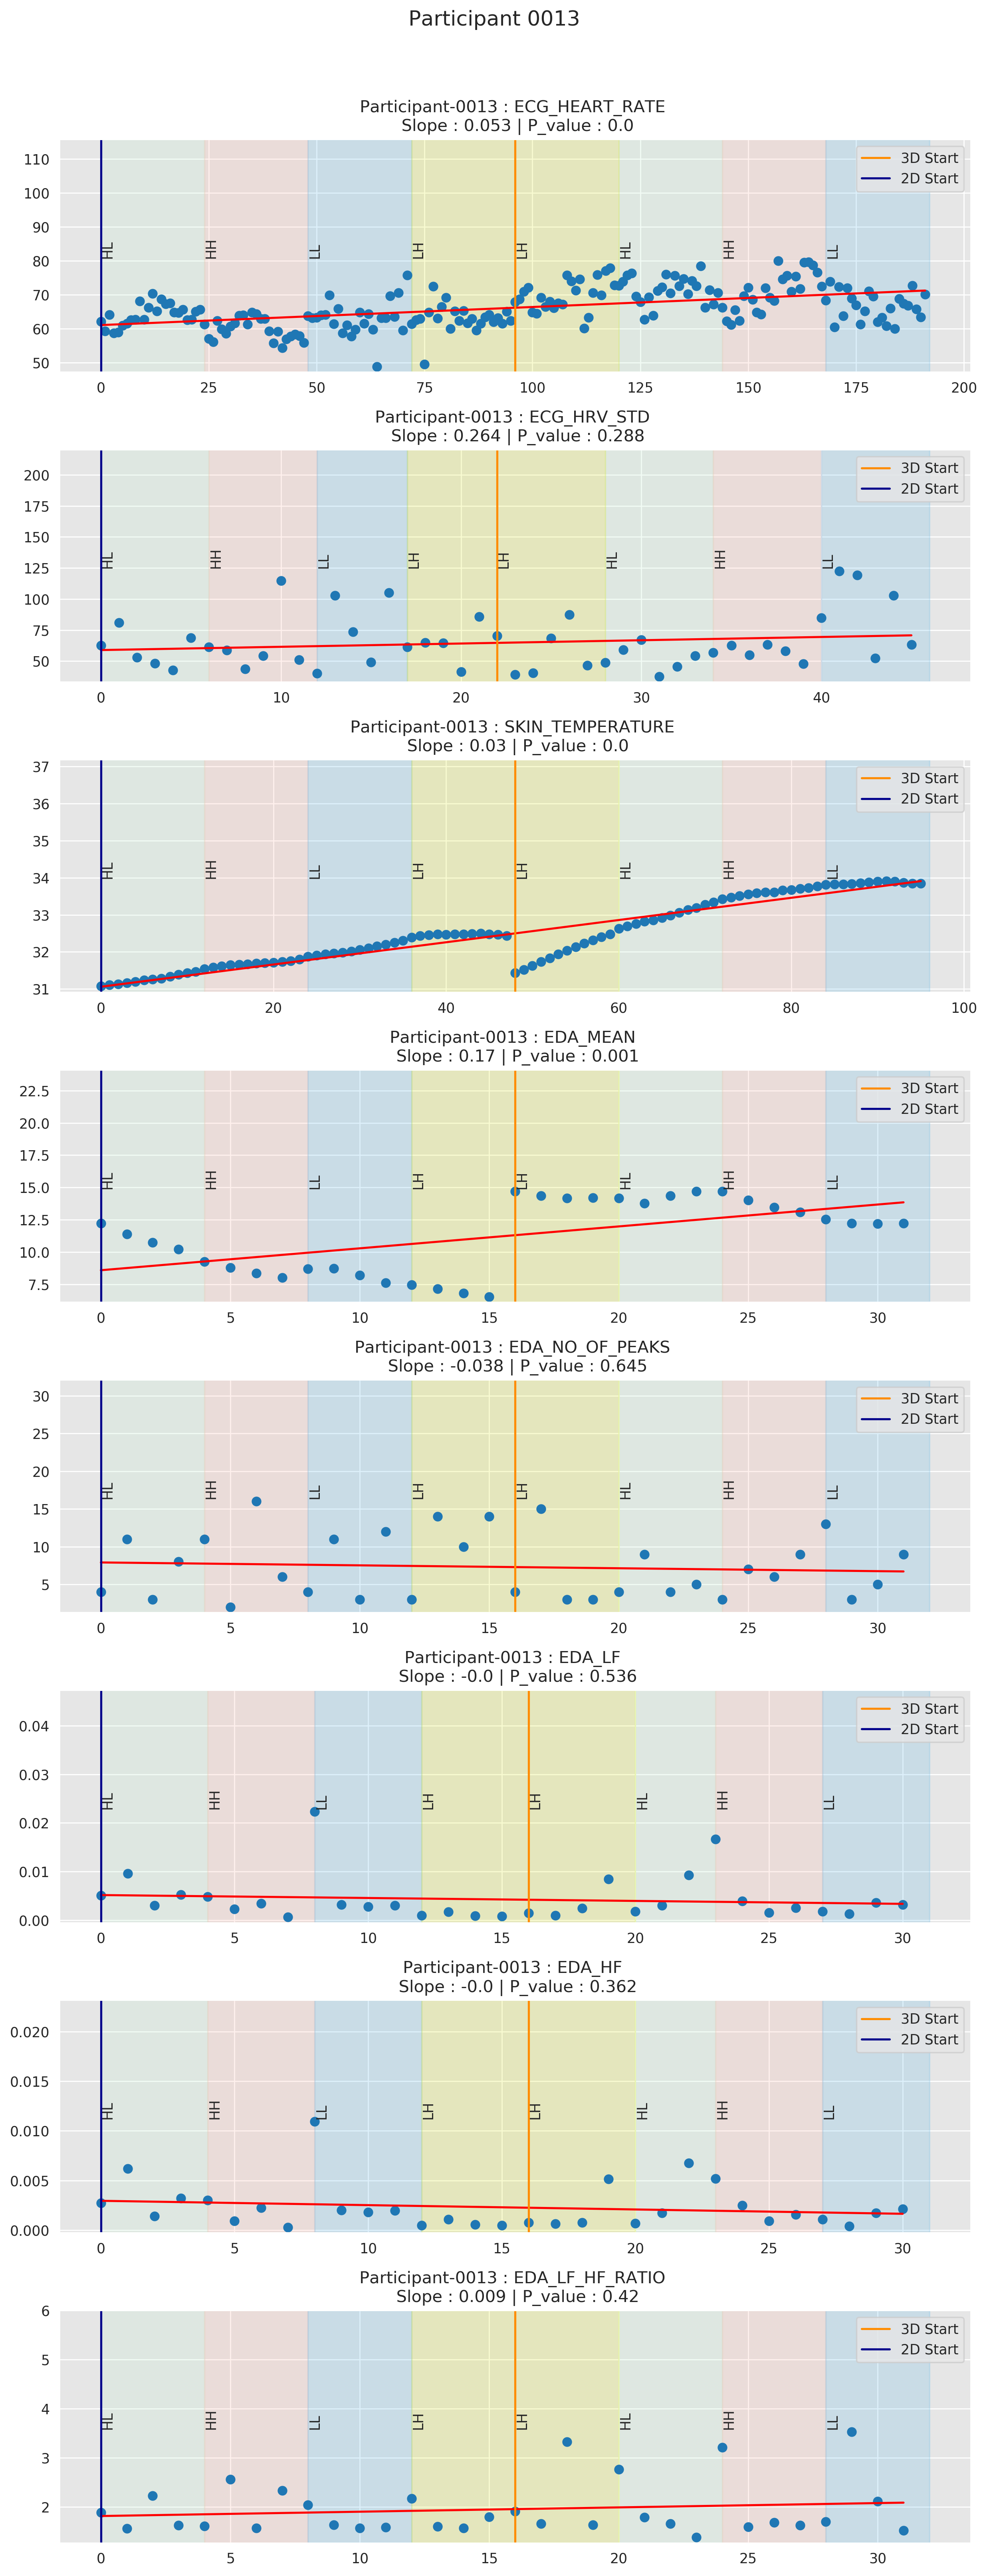

In [22]:
some_participants.groupby("Participant").apply(lambda x: plot_all_data(x.index.get_level_values("Participant").unique().values[0],
                                                            x, slopes_all))